In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Install kaggle API
!pip install kaggle

In [3]:
# Set Kaggle Configuration
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

In [5]:
# Download the dataset
!kaggle datasets download -d shashwatwork/cerebral-stroke-predictionimbalaced-dataset

100% 560k/560k [00:00<00:00, 936kB/s]
100% 560k/560k [00:00<00:00, 935kB/s]


In [6]:
import zipfile

# Define the path to your zip file
file_path = '/content/cerebral-stroke-predictionimbalaced-dataset.zip'

# Unzip the file to a specific destination
with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/kaggle')

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import pandas as pd

In [8]:


cereb_stroke = pd.read_csv('/content/drive/MyDrive/kaggle/dataset.csv')
cereb_stroke.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,NaN,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,NaN,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,NaN,0


In [9]:
# Let me see the summary statistics of numerical columns in the dataset
cereb_stroke.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,41938.000000,43400.000000
mean,36326.142350,42.217894,0.093571,0.047512,104.482750,28.605038,0.018041
std,21072.134879,22.519649,0.291235,0.212733,43.111751,7.770020,0.133103
min,1.000000,0.080000,0.000000,0.000000,55.000000,10.100000,0.000000
25%,18038.500000,24.000000,0.000000,0.000000,77.540000,23.200000,0.000000
50%,36351.500000,44.000000,0.000000,0.000000,91.580000,27.700000,0.000000
75%,54514.250000,60.000000,0.000000,0.000000,112.070000,32.900000,0.000000
max,72943.000000,82.000000,1.000000,1.000000,291.050000,97.600000,1.000000


In [10]:
cereb_stroke.corr()

<ipython-input-10-d2cb50a7d5ad>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cereb_stroke.corr()


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
id,1.000000,0.012760,0.006571,0.009234,0.024634,0.018839,0.002976
age,0.012760,1.000000,0.272169,0.250188,0.237627,0.358897,0.156049
hypertension,0.006571,0.272169,1.000000,0.119777,0.160211,0.161225,0.075332
heart_disease,0.009234,0.250188,0.119777,1.000000,0.146938,0.057677,0.113763
avg_glucose_level,0.024634,0.237627,0.160211,0.146938,1.000000,0.191295,0.078917
bmi,0.018839,0.358897,0.161225,0.057677,0.191295,1.000000,0.020285
stroke,0.002976,0.156049,0.075332,0.113763,0.078917,0.020285,1.000000


In [11]:
# Let me check for null values and see the datatype of each column
cereb_stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 43400 non-null  int64  
 1   gender             43400 non-null  object 
 2   age                43400 non-null  float64
 3   hypertension       43400 non-null  int64  
 4   heart_disease      43400 non-null  int64  
 5   ever_married       43400 non-null  object 
 6   work_type          43400 non-null  object 
 7   Residence_type     43400 non-null  object 
 8   avg_glucose_level  43400 non-null  float64
 9   bmi                41938 non-null  float64
 10  smoking_status     30108 non-null  object 
 11  stroke             43400 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


### There are 43400 in the dataset, however bmi and smoking columns have missing values

# **Exploratory Data Analysis (EDA)**

In [12]:
# Check number of unique values for each feature
cereb_stroke.nunique().sort_values().to_frame()

,0
hypertension,2
heart_disease,2
ever_married,2
Residence_type,2
stroke,2
gender,3
smoking_status,3
work_type,5
age,104
bmi,555


In [13]:
# Filter the dataset to include only entries where stroke is present
stroke_df = cereb_stroke[cereb_stroke['stroke'] == 1]

# Number of people that have stroke
num_stroke = len(stroke_df)

# Percentage with stroke
percentage_stroke = (num_stroke/ len(cereb_stroke))*100
print(f"{num_stroke} people out of {len(cereb_stroke)} people are with stroke. That is about {percentage_stroke:.2f}% of the entire dataset ")

783 people out of 43400 people are with stroke. That is about 1.80% of the entire dataset 


In [14]:
# prevalent age with stroke
prevalent_age = stroke_df['age'].mode()[0]
print(prevalent_age)

79.0


In [15]:
cereb_stroke_by_bmi = stroke_df['bmi'].value_counts()
cereb_stroke_by_bmi

30.9    9
31.4    9
26.4    9
26.6    9
30.7    8
       ..
35.3    1
42.9    1
43.6    1
40.0    1
44.4    1
Name: bmi, Length: 233, dtype: int64

In [16]:
def count(stroke_df, column_name):
  # Check Cereb stroke by age
  number = stroke_df[column_name].value_counts().reset_index()
  number.columns = [column_name, 'count']
  # Convert to dataframe
  number_df= pd.DataFrame(number)
  return number
cereb_stroke_by_age= count(stroke_df, 'age')
cereb_stroke_by_age


,age,count
0,79.00,70
1,78.00,57
2,80.00,49
3,81.00,43
4,82.00,36
5,70.00,25
6,77.00,24
7,74.00,24
8,76.00,24
9,75.00,23


In [17]:
# Function to count Cereb stroke based on the values of the features
def count_people_with_stroke(stroke_df, column_name):
    # Check Cereb stroke by the specified column
    count_df = stroke_df[column_name].value_counts().reset_index()
    count_df.columns = [column_name, 'count']
    return pd.DataFrame(count_df)

# Check Cereb stroke by age
cereb_stroke_by_age_df = count_people_with_stroke(stroke_df, 'age')

# Check Cereb stroke by bmi
cereb_stroke_by_bmi_df = count_people_with_stroke(stroke_df, 'bmi')

# Check Cereb stroke by average glucose level
cereb_stroke_by_glucose_df = count_people_with_stroke(stroke_df, 'avg_glucose_level')

# Check Cereb stroke by work type
cereb_stroke_by_work_type_df = count_people_with_stroke(stroke_df, 'work_type')

# Check Cereb stroke by hypertension
cereb_stroke_by_hypertension_df = count_people_with_stroke(stroke_df, 'hypertension')

# Check Cereb stroke by heart disease status
cereb_stroke_by_heart_disease_df = count_people_with_stroke(stroke_df, 'heart_disease')

# Check Cereb stroke by marital status
cereb_stroke_by_ever_married_df = count_people_with_stroke(stroke_df, 'ever_married')

# Check Cereb stroke by residence type
cereb_stroke_by_residence_type_df = count_people_with_stroke(stroke_df, 'Residence_type')

# Check Cereb stroke by gender
cereb_stroke_by_gender_df = count_people_with_stroke(stroke_df, 'gender')

# Check Cereb stroke by smoking status
cereb_stroke_by_smoking_status_df = count_people_with_stroke(stroke_df, 'smoking_status')

In [18]:
(cereb_stroke_by_age).sort_values(by = 'age', ascending= False)

,age,count
4,82.00,36
3,81.00,43
2,80.00,49
0,79.00,70
1,78.00,57
6,77.00,24
8,76.00,24
9,75.00,23
7,74.00,24
21,73.00,15


In [19]:
age= stroke_df['age'].unique()
age.shape #cereb_stroke_by_age.shape

(55,)

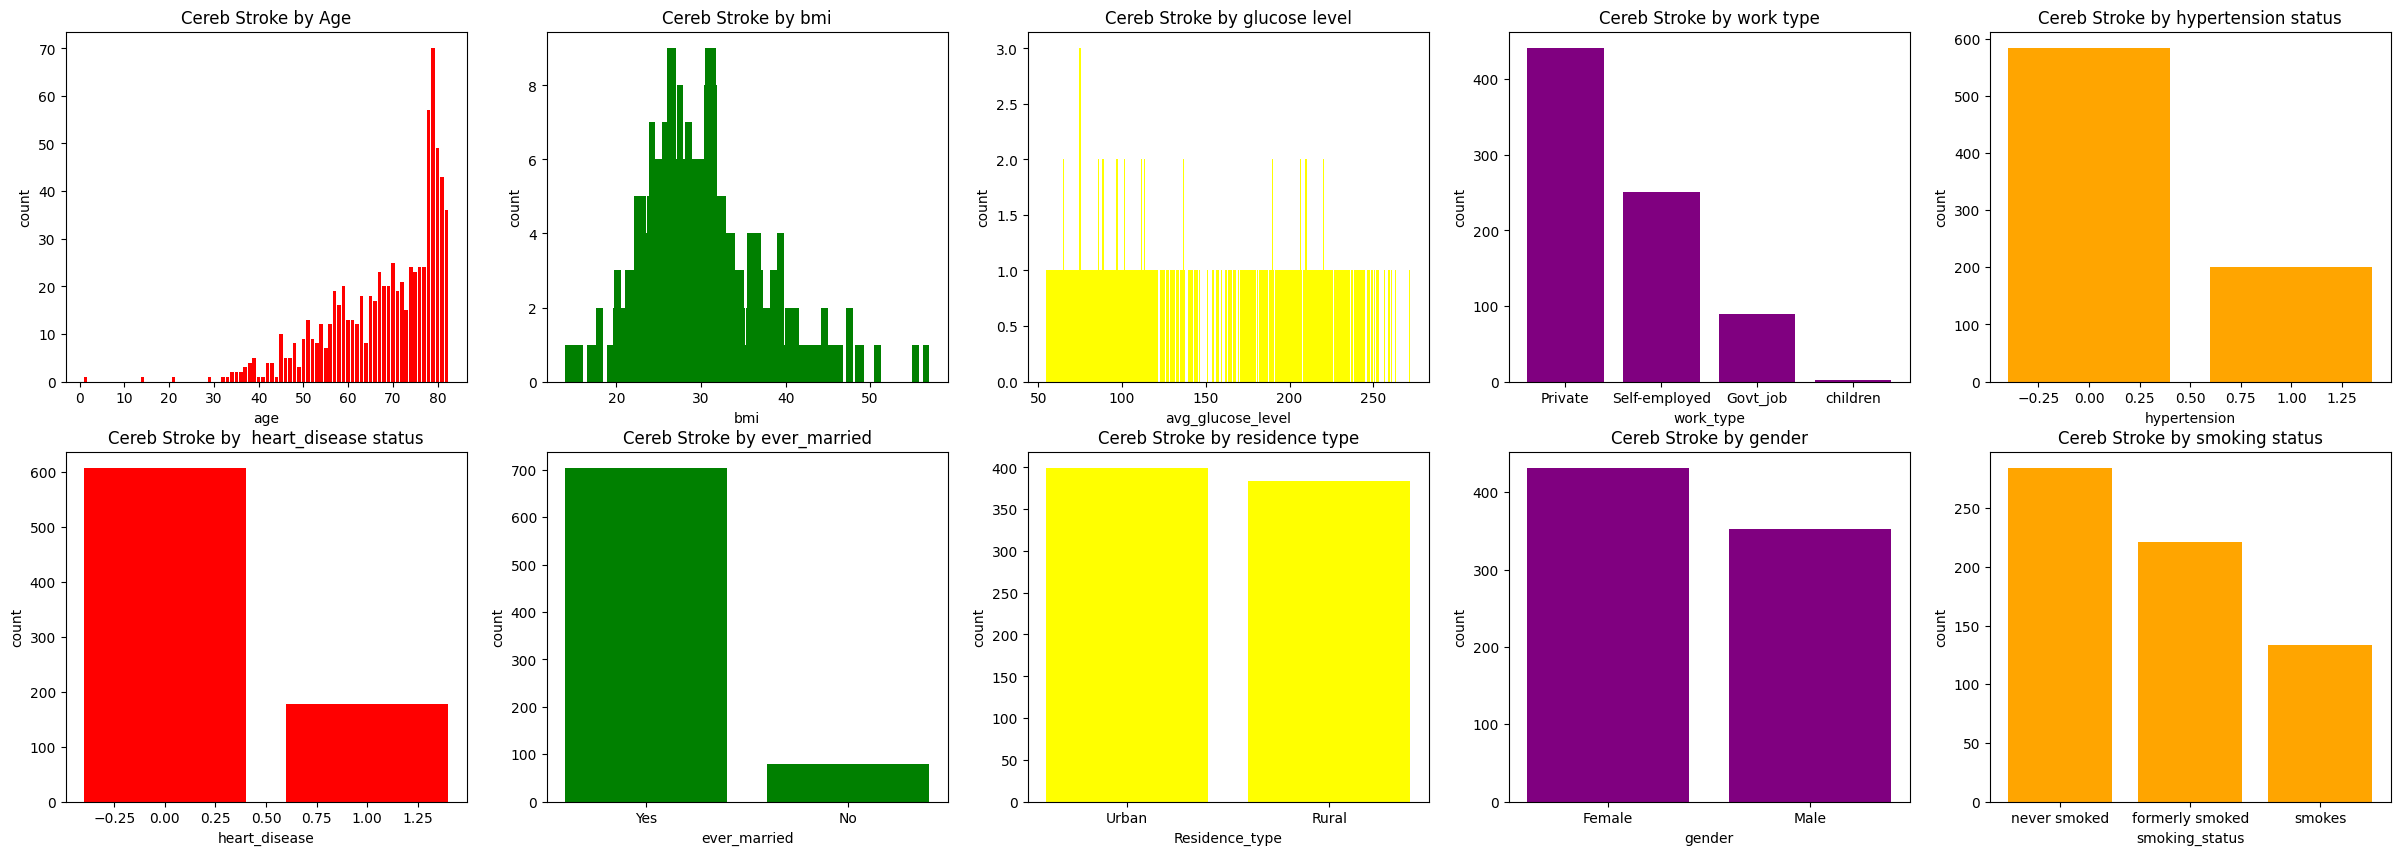

In [20]:
# Visualizing the values in the dataset
import matplotlib.pyplot as plt
def plot_data(axs, dataframe, column1, column2, title, color):
  axs.bar(dataframe[column1], dataframe[column2], color=color)
  axs.set_xlabel(column1)
  axs.set_ylabel(column2)
  axs.set_title(title)

fig, axs = plt.subplots(2, 5, figsize=(30, 10))

# Plot people with stroke by age
plot_data(axs[0, 0],cereb_stroke_by_age_df,  'age', 'count', 'Cereb Stroke by Age', 'red')

# Plot people with stroke by BMI
plot_data(axs[0, 1],cereb_stroke_by_bmi_df,  'bmi', 'count', 'Cereb Stroke by bmi', 'green')

# Plot people with stroke by average glucose level
plot_data(axs[0, 2],cereb_stroke_by_glucose_df,  'avg_glucose_level', 'count', 'Cereb Stroke by glucose level', 'yellow')

# Plot people with stroke by work type
plot_data(axs[0, 3],cereb_stroke_by_work_type_df,  'work_type', 'count', 'Cereb Stroke by work type', 'purple')

# Plot people with stroke by hypertension status
plot_data(axs[0, 4],cereb_stroke_by_hypertension_df,  'hypertension', 'count', 'Cereb Stroke by hypertension status', 'orange')

# Plot people with stroke by heart_disease status
plot_data(axs[1, 0],cereb_stroke_by_heart_disease_df,  'heart_disease', 'count', 'Cereb Stroke by  heart_disease status', 'red')

# Plot people with stroke by ever_married
plot_data(axs[1, 1],cereb_stroke_by_ever_married_df,  'ever_married', 'count', 'Cereb Stroke by ever_married', 'green')

# Plot people with stroke by Residence_type
plot_data(axs[1, 2],cereb_stroke_by_residence_type_df,  'Residence_type', 'count', 'Cereb Stroke by residence type', 'yellow')

# Plot people with stroke by gender
plot_data(axs[1, 3],cereb_stroke_by_gender_df,  'gender', 'count', 'Cereb Stroke by gender', 'purple')

# Plot people with stroke by smoking_status
plot_data(axs[1, 4],cereb_stroke_by_smoking_status_df,  'smoking_status', 'count', 'Cereb Stroke by smoking status', 'orange')
plt.savefig('celeb_stroke_barcharts.png')

In [21]:
cereb_stroke_by_hypertension_df

,hypertension,count
0,0,583
1,1,200


In [22]:
cereb_stroke_by_glucose_df[:16]

,avg_glucose_level,count
0,74.95,3
1,210.08,2
2,136.79,2
3,85.94,2
4,101.45,2
5,96.97,2
6,111.81,2
7,206.74,2
8,88.57,2
9,65.12,2


In [23]:
cereb_stroke_by_work_type_df

,work_type,count
0,Private,441
1,Self-employed,251
2,Govt_job,89
3,children,2


In [24]:
cereb_stroke_by_ever_married_df

,ever_married,count
0,Yes,703
1,No,80


In [25]:
703/783

0.8978288633461047

### Findings:

Only **783** people out of **43,400** people in the dataset had cerebral stroke i.e. about **1.8%**

The following result from the barchart above is really suprising:

1. That the **BMI** (body mass index), the **average glucose level**, **hypertension status**, **heart disease status** and **residence type** do not really contribute to cerebral stroke.
2.  **Age**, **work type** and **ever married** significantly contribute to the possibility of having cerebral stroke. About 70 out of 783 people with cerebral stroke were 79 years old.
* The dataset reveals that the tendency of having cerebral stroke is higher for people up to **45 years old and above** as 95.53% of the population are up to 45 years.
* People that never worked never had celebral stroke, **56.32%** of the people with cerebral stroke are (were)  private employees, and **32.06%** of them are (were) self employed.
* A whooping **89.78%** of the people  with cerebral stroke have been (were)  married.
3. It is noteworthy that there were slightly higher number of females with cerebral stroke than males.
4.  **18.52% (145)** of the people with cerebral stroke did not disclose their **smoking status**  and **45.21%** of them smoke or used to smoke.

# **Data Wrangling**

In [26]:
# Check for missing values in the dataset
cereb_stroke.isnull().sum()

id                       0
gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

In [27]:
cereb_stroke_by_smoking_status_df


,smoking_status,count
0,never smoked,284
1,formerly smoked,221
2,smokes,133


#### There are some missing data!
13,292 people did not disclose their smoking status, and 1462 did not disclose their BMI.

I will fill in the BMI with the mean bmi, and fill in the smoking status with the mode (most occuring) smoking status.

In [28]:
# Fill missing numerical values with the mean
cereb_stroke['bmi'].fillna(cereb_stroke['bmi'].mean(), inplace=True)

# Fill missing categorical values with the most frequent category
cereb_stroke['smoking_status'].fillna(cereb_stroke['smoking_status'].mode()[0], inplace=True)

In [29]:
cereb_stroke.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [30]:
cereb_stroke['smoking_status'].value_counts()

never smoked       29345
formerly smoked     7493
smokes              6562
Name: smoking_status, dtype: int64

## **Feature Engineering**

In [31]:
cereb_stroke_2 = cereb_stroke.drop('id', axis=1)
cereb_stroke_2.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,3.0,0,0,No,children,Rural,95.12,18.0,never smoked,0
1,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,Female,8.0,0,0,No,Private,Urban,110.89,17.6,never smoked,0
3,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,never smoked,0


In [32]:
# Split the dataset into x and y
x = cereb_stroke_2.drop('stroke', axis=1)
y = cereb_stroke_2['stroke']

In [33]:
# Check the shape of x and y
x.shape, y.shape

((43400, 10), (43400,))

### Preparing data for random forest classification

In [34]:
# train the data with random forest algorithm
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score



# List of categorical variables
categorical_vars = ['gender', 'hypertension', 'heart_disease', 'ever_married',
                    'work_type', 'Residence_type', 'smoking_status']
x_num = ['age', 'bmi', 'avg_glucose_level']

# Encode categorical variables using one-hot encoding
encoder = OneHotEncoder()
x_cat_encoded = encoder.fit_transform(x[categorical_vars])

# Combine encoded categorical features with numerical features
x_combined = np.concatenate((x_cat_encoded.toarray(), x[x_num]), axis=1)

# Compute mutual information scores
mutual_info_scores = mutual_info_classif(x_combined, y)

# Select top k features based on mutual information scores
k = 5
selected_features_indices = np.argsort(mutual_info_scores)[-k:]

# Use selected feature indices to subset the combined feature matrix
x_selected = x_combined[:, selected_features_indices]
x_selected, x_selected.shape

(array([[ 1.,  1.,  0.,  1.,  3.],
        [ 0.,  1.,  1.,  1., 58.],
        [ 1.,  1.,  0.,  1.,  8.],
        ...,
        [ 0.,  0.,  1.,  1., 82.],
        [ 1.,  1.,  1.,  1., 40.],
        [ 1.,  1.,  1.,  1., 82.]]),
 (43400, 5))

In [35]:
from imblearn.over_sampling import RandomOverSampler

# Instantiate the RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Perform oversampling
x_resampled, y_resampled = oversampler.fit_resample(x_selected, y)
x_resampled.shape, y_resampled.shape

((85234, 5), (85234,))

In [36]:
# Split x and y into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size= 0.2, random_state= 42)

# check the length of x_train, x_test, y_train, y_test
x_train.shape, len(x_test), len(y_train), len(y_test)

((68187, 5), 17047, 68187, 17047)

## **Modelling**

In [37]:
# train the data with random forest algorithm
# from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

rfc = RandomForestClassifier(criterion = 'entropy', random_state = 42)
rfc.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', random_state=42)

In [38]:
# make prediction with the rfc model
y_pred = rfc.predict(x_test)
y_pred, y_pred.shape

(array([1, 1, 1, ..., 1, 0, 1]), (17047,))

In [39]:
# Check if y_pred is equal to y_test
comparison = y_pred == y_test

# Count the number of false predictions
false_count = len(comparison) - sum(comparison)

# Output the false predictions and count of false
false_indices = np.where(~comparison)[0]
print("False predictions:", false_indices)
print("Count of false predictions:", false_count)

False predictions: [   11    15    16 ... 17038 17039 17044]
Count of false predictions: 3239


### Model evaluation


In [40]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[6420, 2080],
       [1159, 7388]])

In [41]:
from sklearn.metrics import  classification_report
target_names = ['no_stroke', 'stroke']
print(classification_report(y_true = y_test, y_pred = y_pred, target_names= target_names ))

              precision    recall  f1-score   support

   no_stroke       0.85      0.76      0.80      8500
      stroke       0.78      0.86      0.82      8547

    accuracy                           0.81     17047
   macro avg       0.81      0.81      0.81     17047
weighted avg       0.81      0.81      0.81     17047

